# Misclassifications Analysis and Average Model
In this notebook we will do an analysis of the misclassifications made by our models, to understand whether it is actually useful to use an ensemble technique.

# Import libraries

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import scipy
import os
import string
import csv
import random as rn
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import re
from string import punctuation
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Dropout, LSTM

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
import shutil
from sklearn import metrics
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from sklearn.utils import class_weight
from keras import backend as K

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Load dataset

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cp --verbose -R "/content/drive/MyDrive/Quora/Dataset" "/content"

'/content/drive/MyDrive/Quora/Dataset' -> '/content/Dataset'
'/content/drive/MyDrive/Quora/Dataset/validation.csv' -> '/content/Dataset/validation.csv'
'/content/drive/MyDrive/Quora/Dataset/test.csv' -> '/content/Dataset/test.csv'
'/content/drive/MyDrive/Quora/Dataset/training.csv' -> '/content/Dataset/training.csv'
'/content/drive/MyDrive/Quora/Dataset/augmented_training.csv' -> '/content/Dataset/augmented_training.csv'
'/content/drive/MyDrive/Quora/Dataset/val_cosine_score.csv' -> '/content/Dataset/val_cosine_score.csv'


# Set parameters

In [4]:
DATASET_PATH = '/content/Dataset'
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Quora/Models"

# Utility functions

In [5]:
def txt_process(input_text):
  '''
  txt_process is used to preprocess a question
  :param input_text: input string
  :return: the cleaned version of the input string
  '''
  # Removing punctuation from input text
  input_text = ''.join([x for x in input_text if x not in punctuation])
  # Cleaning the text
  input_text = re.sub(r"[^A-Za-z0-9]", " ", input_text)
  input_text = re.sub(r"\'s", " ", input_text)
  # remove stop words
  input_text = input_text.split()
  input_text = [x for x in input_text if not x in stop_words]
  input_text = " ".join(input_text)
  # return a list of words
  return(input_text)

def evaluate_ensemble(y_score, y_pred, y_true):
  '''
  evaluate_ensemble is used to plot some statistics about the performance on the test set
  '''
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

# Prepare dataset and models

## LSTM models

In [6]:
train_questions = pd.read_csv(DATASET_PATH + '/training.csv')
validation_questions = pd.read_csv(DATASET_PATH + '/validation.csv')
test_questions = pd.read_csv(DATASET_PATH + '/test.csv')

train_questions['question1_cleaned'] = train_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
train_questions['question2_cleaned'] = train_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

validation_questions['question1_cleaned'] = validation_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
validation_questions['question2_cleaned'] = validation_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

test_questions['question1_cleaned'] = test_questions.apply(lambda x: txt_process(x['question1']), axis = 1)
test_questions['question2_cleaned'] = test_questions.apply(lambda x: txt_process(x['question2']), axis = 1)

question_text = np.hstack([train_questions.question1_cleaned, train_questions.question2_cleaned])
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(question_text)

max_len_tokenizers = 25
m_len = max_len_tokenizers * 2

validation_questions['tokenizer_1'] = tokenizer.texts_to_sequences(validation_questions.question1_cleaned)
validation_questions['tokenizer_1'] = sequence.pad_sequences(validation_questions.tokenizer_1, maxlen = max_len_tokenizers, padding='post', truncating='post').tolist()
validation_questions['tokenizer_2'] = tokenizer.texts_to_sequences(validation_questions.question2_cleaned)
validation_questions['tokenizer_2'] = sequence.pad_sequences(validation_questions.tokenizer_2, maxlen = max_len_tokenizers, padding='post', truncating='post').tolist()

test_questions['tokenizer_1'] = tokenizer.texts_to_sequences(test_questions.question1_cleaned)
test_questions['tokenizer_1'] = sequence.pad_sequences(test_questions.tokenizer_1, maxlen = max_len_tokenizers, padding='post', truncating='post').tolist()
test_questions['tokenizer_2'] = tokenizer.texts_to_sequences(test_questions.question2_cleaned)
test_questions['tokenizer_2'] = sequence.pad_sequences(test_questions.tokenizer_2, maxlen = max_len_tokenizers, padding='post', truncating='post').tolist()

validation_questions['tokenizer'] = validation_questions['tokenizer_1'] + validation_questions['tokenizer_2']
test_questions['tokenizer'] = test_questions['tokenizer_1'] + test_questions['tokenizer_2']

y_test = test_questions[['is_duplicate']]
y_true = y_test.values.squeeze().tolist()
X_test_lstm = test_questions[['tokenizer']]
X_test_lstm = sequence.pad_sequences(X_test_lstm.tokenizer, maxlen = m_len, padding='post', truncating='post')

y_validation_true = validation_questions[['is_duplicate']].squeeze().tolist()
X_validation_lstm = validation_questions[['tokenizer']]
X_validation_lstm = sequence.pad_sequences(X_validation_lstm.tokenizer, maxlen = m_len, padding='post', truncating='post')

In [7]:
lstm_model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/LSTM/BI_LSTM64_augmentation.h5')
lstm_model_basic = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/LSTM/BI_LSTM64.h5')

## Transfer Learning Models

In [8]:
X_test_doc2Vec = np.load('/content/drive/MyDrive/Quora/Features/Doc2Vec/test/full_question_doc2vec.npy')
X_test_miniLM = np.load('/content/drive/MyDrive/Quora/Features/Sentence BERT/test/full_question_sBERT.npy')
X_test_mpnet = np.load('/content/drive/MyDrive/Quora/Features/all-mpnet-base-v2/test/full_question_mpnet.npy')
X_test_distil_roberta = np.load('/content/drive/MyDrive/Quora/Features/all-distilroberta-v1/test/full_question_distilroberta.npy')

X_validation_doc2Vec = np.load('/content/drive/MyDrive/Quora/Features/Doc2Vec/validation/full_question_doc2vec.npy')
X_validation_miniLM = np.load('/content/drive/MyDrive/Quora/Features/Sentence BERT/validation/full_question_sBERT.npy')
X_validation_mpnet = np.load('/content/drive/MyDrive/Quora/Features/all-mpnet-base-v2/validation/full_question_mpnet.npy')
X_validation_distil_roberta = np.load('/content/drive/MyDrive/Quora/Features/all-distilroberta-v1/validation/full_question_distilroberta.npy')

In [9]:
doc2Vec_model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Transfer Learning/doc2vec_DL_pace16.h5')
miniLM_model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Transfer Learning/sentBERT_DL_pace96_aug_weighted.h5')
mpnet_model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Transfer Learning/mpnet_DL_pace128_weighted.h5')
distil_roberta_model = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Transfer Learning/distilroberta_DL_halving2.h5')

# Analysis of missclassification

In [10]:
num_models = 6

In [11]:
lstm_model_y_score = lstm_model.predict(X_test_lstm)
lstm_model_basic_y_score = lstm_model_basic.predict(X_test_lstm)
doc2Vec_model_y_score = doc2Vec_model.predict(X_test_doc2Vec)
miniLM_model_y_score = miniLM_model.predict(X_test_miniLM)
mpnet_model_y_score = mpnet_model.predict(X_test_mpnet)
distil_roberta_model_y_score = distil_roberta_model.predict(X_test_distil_roberta)
siamese_model_y_score = np.load('/content/drive/MyDrive/Quora/Predictions/test_scores_siamese.npy')
distil_roberta_ensemble_y_score = np.load('/content/drive/MyDrive/Quora/Predictions/predicted_test.npy')

In [12]:
lstm_model_y_pred = np.rint(lstm_model_y_score)
lstm_model_basic_y_pred = np.rint(lstm_model_basic_y_score)
doc2Vec_model_y_pred = np.rint(doc2Vec_model_y_score)
miniLM_model_y_pred = np.rint(miniLM_model_y_score)
mpnet_model_y_pred = np.rint(mpnet_model_y_score)
distil_roberta_model_y_pred = np.rint(distil_roberta_model_y_score)
siamese_model_y_pred = np.rint(siamese_model_y_score)
distil_roberta_ensemble_y_pred = np.rint(distil_roberta_ensemble_y_score)

In [13]:
labels = []
for i in range(len(y_true)):
  labels.append([int(y_true[i]), int(doc2Vec_model_y_pred[i]), int(miniLM_model_y_pred[i]), int(mpnet_model_y_pred[i]), int(distil_roberta_model_y_pred[i]), int(siamese_model_y_pred[i]), int(lstm_model_basic_y_pred[i])])

# in misclassifications we have the number of classifiers who miss each prediction
misclassifications = [len(label) - label.count(label[0]) for label in labels]
print("Misclassified pairs from 1 classifiers: ", misclassifications.count(1))
print("Misclassified pairs from 2 classifiers: ", misclassifications.count(2))
print("Misclassified pairs from 3 classifiers: ", misclassifications.count(3))
print("Misclassified pairs from 4 classifiers: ", misclassifications.count(4))
print("Misclassified pairs from 5 classifiers: ", misclassifications.count(5))
print("Misclassified pairs from 6 classifiers: ", misclassifications.count(6))

Misclassified pairs from 1 classifiers:  8440
Misclassified pairs from 2 classifiers:  4324
Misclassified pairs from 3 classifiers:  2811
Misclassified pairs from 4 classifiers:  1843
Misclassified pairs from 5 classifiers:  1246
Misclassified pairs from 6 classifiers:  689


In [14]:
misclassifications_classifier = []
for i in range(len(labels)):
  if labels[i].count(labels[i][0]) == len(labels[i]): # if all classifiers are good in the prediction
    misclassifications_classifier.append([]) 
    continue
  wrong_classifiers = [index for index, predicted_class in enumerate(labels[i]) if predicted_class != labels[i][0]]
  misclassifications_classifier.append(wrong_classifiers) 

In [15]:
print("Pairs misclassified by all classifiers: ", len([1 for misclassification in misclassifications_classifier if len(misclassification) == num_models]))
print("--------")
print("Pairs misclassified only with Doc2Vec: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 1 in misclassification]))
print("Pairs correctly classified only with Doc2Vec: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == num_models-1 and 1 not in misclassification]))
print("--------")
print("Pairs misclassified only with MiniLM-L12-v2: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 2 in misclassification]))
print("Pairs correctly classified only with MiniLM-L12-v2: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == num_models-1 and 2 not in misclassification]))
print("--------")
print("Pairs misclassified only with All-mpnet-base-v2: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 3 in misclassification]))
print("Pairs correctly classified only with All-mpnet-base-v2: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == num_models-1 and 3 not in misclassification]))
print("--------")
print("Pairs misclassified only with Distil-Roberta: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 4 in misclassification]))
print("Pairs correctly classified only with Distil-Roberta: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == num_models-1 and 4 not in misclassification]))

print("--------")
print("Pairs misclassified only with Siamese: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 5 in misclassification]))
print("Pairs correctly classified only with Siamese: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == num_models-1 and 5 not in misclassification]))

print("--------")
print("Pairs misclassified only with LSTM: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == 1 and 6 in misclassification]))
print("Pairs correctly classified only with LSTM: ", len([1 for misclassification in misclassifications_classifier 
                                                                 if len(misclassification) == num_models-1 and 6 not in misclassification]))

Pairs misclassified by all classifiers:  689
--------
Pairs misclassified only with Doc2Vec:  3838
Pairs correctly classified only with Doc2Vec:  380
--------
Pairs misclassified only with MiniLM-L12-v2:  614
Pairs correctly classified only with MiniLM-L12-v2:  155
--------
Pairs misclassified only with All-mpnet-base-v2:  575
Pairs correctly classified only with All-mpnet-base-v2:  160
--------
Pairs misclassified only with Distil-Roberta:  596
Pairs correctly classified only with Distil-Roberta:  182
--------
Pairs misclassified only with Siamese:  1123
Pairs correctly classified only with Siamese:  171
--------
Pairs misclassified only with LSTM:  1694
Pairs correctly classified only with LSTM:  198


# Ensemble - Average Model
Let's see now what happens if we simply consider an average model.

In [16]:
num_models = 6
test_scores = [doc2Vec_model_y_score, miniLM_model_y_score, mpnet_model_y_score, distil_roberta_model_y_score, siamese_model_y_score, lstm_model_basic_y_score]

In [17]:
ensemble_scores = []
n_models = len(test_scores)
for i in range(len(y_true)):
  ensemble_scores.append(np.sum([(1/num_models)*model_score[i] for model_score in test_scores]))

ensemble_predictions = np.rint(ensemble_scores)

Classification report: 
              precision    recall  f1-score   support

           0     0.9170    0.8937    0.9052     25348
           1     0.8287    0.8640    0.8460     15080

    accuracy                         0.8826     40428
   macro avg     0.8728    0.8789    0.8756     40428
weighted avg     0.8840    0.8826    0.8831     40428



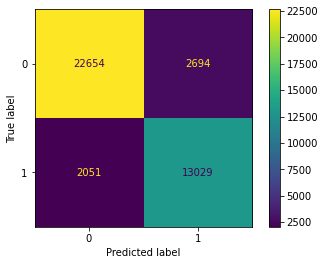

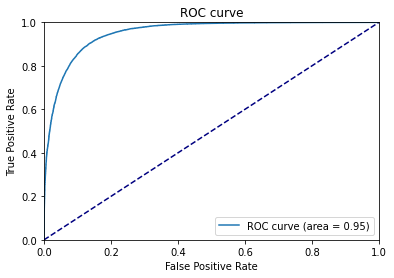

In [18]:
evaluate_ensemble(ensemble_scores, ensemble_predictions, y_true)